In [1]:
import numpy as np
import yaml, os
from sys import path
from pathlib import Path
import matplotlib.pyplot as plt
import astropy.units as u
import astropy.constants as const

path.append("opereira/starships/cc_scripts/")

import cc_scripts.reduction as red
import cc_scripts.make_model as mod
import cc_scripts.correlations as corr

from importlib import reload
# red = reload(red)

# unpack input parameters into config dictionary
config_filepath = 'config.yaml'
with open(config_filepath, 'r') as file:
    config_dict = yaml.safe_load(file)

config_dict['obs_dir'] = Path.home() / Path(config_dict['obs_dir'])

# creating the planet and observation objects
planet, obs = red.load_planet(config_dict)

# # Choose which exposures to use
# all_exposures = np.arange(obs.n_spec)
# transit_tags = np.delete(all_exposures, [20, 21, 22, 23, 31, 32, 33])  # Here we exclude the exposures [20, 21, ..., 33]

INFO:starships.planet_obs:Getting WASP-127 b from ExoFile
INFO:starships.planet_obs:Fetching the uncorrected spectra
INFO:starships.planet_obs:File: list_e2ds


Changing M_star from [2.14748266e+30] kg to 1.8889893771631484e+30 kg
It became [1.88898938e+30] kg
Changing R_star from [9.67023e+08] m to 927368100.0 m
It became [9.273681e+08] m
Changing M_pl from [3.12621121e+26] kg to 3.131905585604484e+26 kg
It became [3.13190559e+26] kg
Changing R_pl from [93726012.] m to 93726012.0 m
It became [93726012.] m
Changing RV_sys from [0.] km / s to -8.86 km / s
It became [-8.86] km / s
Changing mid_tr from [2458385.175527] d to 2459575.9239004 d
It became [2459575.9239004] d
Changing t_peri from [2458385.175527] d to 2459575.9239004 d
It became [2459575.9239004] d
Changing trandur from [15670.368] s to 4.3529 h
It became [15670.44] s
Changing period from [360984.827232] s to 4.1780625 d
It became [360984.6] s
Changing excent from 0.0 to 0.0
It became 0.0
Changing incl from [1.5393804] rad to 87.84 deg
It became [1.53309721] rad
Changing Teff from [5620.] K to 5842
It became [5842.] K
Changing Tp from [1400.] K to 1400.0 K
It became [1400.] K
Changing

INFO:starships.planet_obs:Fetching data
INFO:starships.planet_obs:File: list_tellu_corrected
INFO:starships.planet_obs:Fetching the tellurics
INFO:starships.planet_obs:File: list_tellu_recon


In [19]:
'''---------------------------------------Reducing the Data--------------------------------------'''

out_dir, path_fig = red.set_save_location(planet.name, config_dict['reduction'], config_dict['instrument']) # might replace with out_dir from YAML file

# building the transit spectrum
list_tr = red.build_trans_spec(config_dict, obs, planet)

# saving the transit spectrum
red.save_pl_sig(config_dict, list_tr, out_dir, do_tr = [1])

# outputting plots for reduction step
red.reduction_plots(list_tr, config_dict['idx_ord'], path_fig)

Transmission
8, 22

KeyboardInterrupt: 

INFO:cc_scripts.make_model:Model not initialized for mode = high. Starting initialization...
INFO:starships.petitradtrans_utils:Adding H2O_main_iso to species_list
INFO:starships.petitradtrans_utils:['H2O_main_iso']
/home/opereira/.venvs/starships-env/lib/python3.11/site-packages/petitRADTRANS/radtrans.py:100: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "


  Read line opacities of H2O_main_iso...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...


INFO:starships.petitradtrans_utils:Generating atmosphere with pressures from 100.0 to 1e-10
INFO:starships.petitradtrans_utils:You are not getting the individual contributions of the species
INFO:cc_scripts.make_model:Saving values in `linelist_names`.


Done.



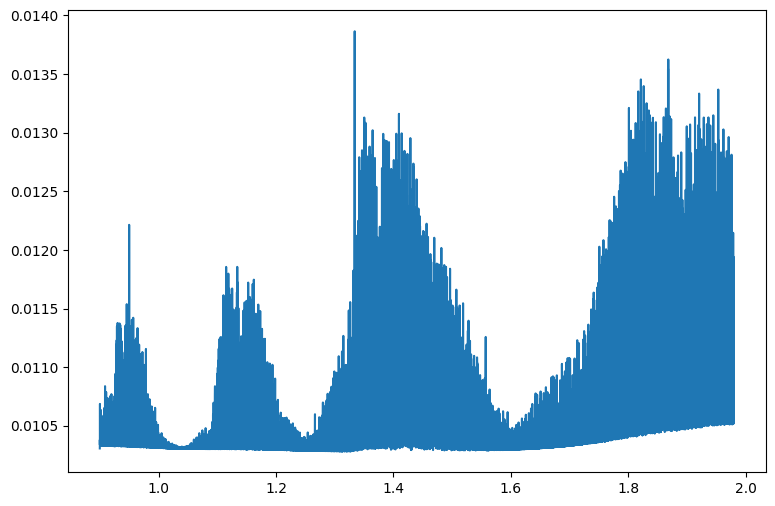

In [2]:
'''-------------------------------------Generating the Model-------------------------------------'''
mod = reload(mod)
# computing extra parameters needed for model making
int_dict = mod.create_internal_dict(config_dict, planet)

# create the model
wave_mod, mod_spec = mod.prepare_model_high_or_low(config_dict, int_dict, planet)

plt.plot(wave_mod, mod_spec)

In [4]:
'''---------------------------------Correlations---------------------------------'''

# 1. standard CCF
corrRV = np.arange(config_dict['RV_range'][0], config_dict['RV_range'][1], config_dict['RV_step'])

from starships.correlation import quick_correl
from starships.correlation_class import Correlations

# Load some model
# model_file = np.load('best_logl_model_HR.npz')
# wave_mod, model_spec = model_file['wave'], model_file['spec']

# Do the correlation
ccf = quick_correl(list_tr['1'].wave, list_tr['1'].final, corrRV, wave_mod, mod_spec, wave_ref=None, 
                     get_logl=False, kind='BL', mod2d=False, expand_mask=0, noise=None, somme=False)

Highest SNR = 4.744505261274837 // Kp = [97] // RV = -6.264501825576999 
Max SNR = 4.42$\sigma$, Max position = -4.64



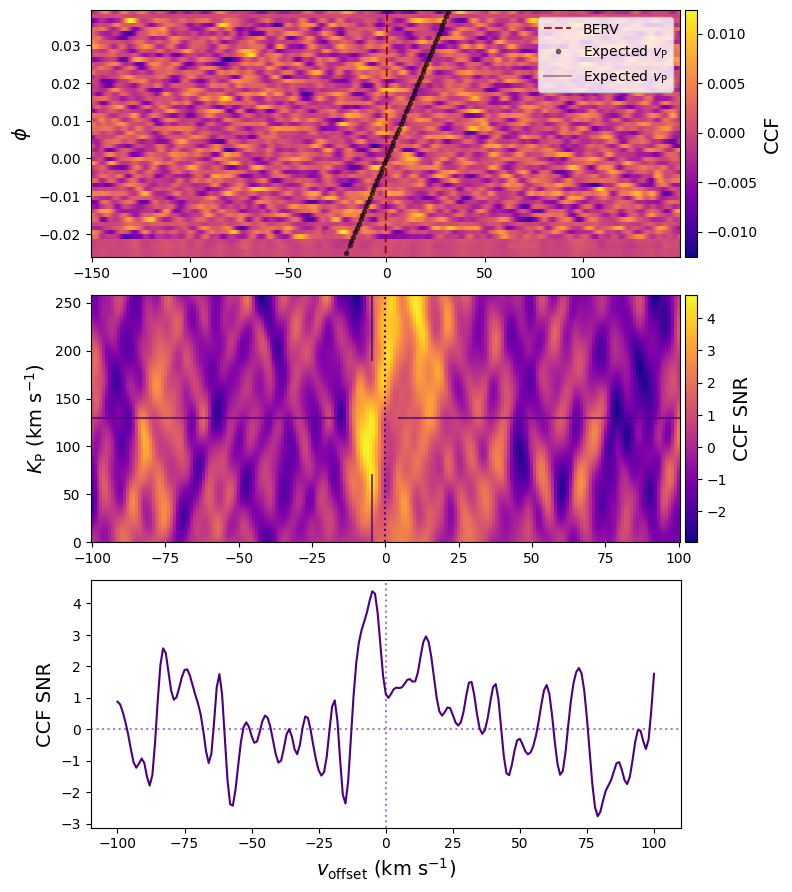

In [5]:
# Create the object do make the plots and compute the different Kp

corr_obj = Correlations(ccf, kind='BL', rv_grid=corrRV, kp_array=list_tr['1'].Kp)
corr_obj.calc_ccf(orders=None, N=list_tr['1'].N_frac[None, :, None], alpha=np.ones_like(list_tr['1'].alpha_frac), index=None, ccf0=None, rm_vert_mean=False,)
corr_obj.calc_correl_snr_2d(list_tr['1'], plot=False)
corr_obj.RV_shift = np.zeros_like(list_tr['1'].alpha_frac)

# Make the plots
corr_obj.full_plot(list_tr['1'], []) #, kind_max='grid')

In [10]:
# 2. quick correlation

# n_RV_inj=101
# n_RV_inj=51
# corrRV0 = np.linspace(-100, 100, n_RV_inj)
# corrRV0 = np.linspace(-50, 50, n_RV_inj)

corrRV = np.arange(config_dict['RV_range'][0], config_dict['RV_range'][1], 3)#config_dict['RV_step'])

n_pcas = [3,4]
# n_pcas = [0,1,2,3,4,5]
# usually first test the true/known Kp for the planet
Kp_array = np.array([ list_tr['1'].Kp.value])  # np.arange(kp0, int(Kp.value*2))


In [11]:
import starships.correlation as correl

loblBL_t1_corr, \
loblBL_t1_sig = correl.quick_calc_logl_injred_class(list_tr['1'], Kp_array, corrRV, n_pcas, 
                                                    wave_mod, np.array(mod_spec), nolog=True, 
                                                    inj_alpha='ones', RVconst=list_tr['1'].RV_const)

Injecting model w/ alpha = ones
 Previous N_pc = 3, changing to 4  84, File = 1/1, RV = 100/100  
Building final transmission spectrum with 4 n_pc
flux_norm all nan : False
flux_Sref all nan : False
flux_masked all nan : False
flux_norm_mo all nan : False
master_out all nan : False
Removing the static noise with PCA and sigma cliping 
(56, 75, 4088)
spec_trans all nan : False
clean_ts all nan : False
Removing the mean 
Removing the remaining high variance pixels. 

Removing the mean. 


Max value at 4 npc = 2.6988331831489756 at -5.999993550114001 km/s
Max value at 4 npc = 3.4045550064664707 at -5.999993550114001 km/s
Max value at 4 npc = 3.4045550064664707 at -5.999993550114001 km/s
[2.67073695 2.69883318]
[-224227.03914328 -225629.48286026]
[158.2596545 156.3061072]
[    0.         -2804.88743395]


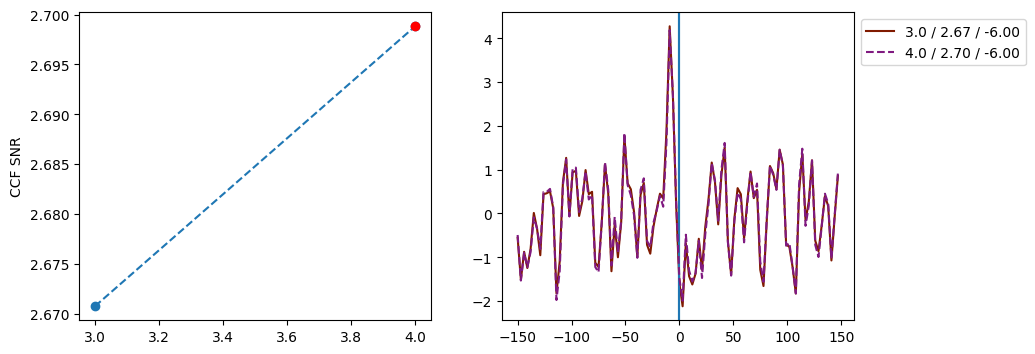

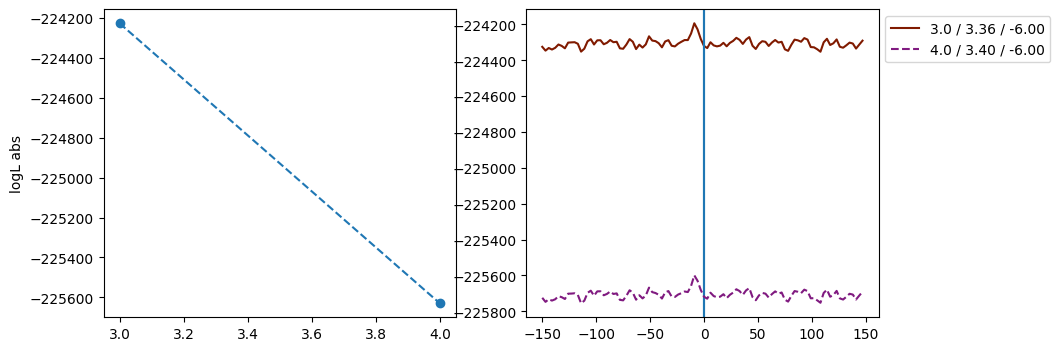

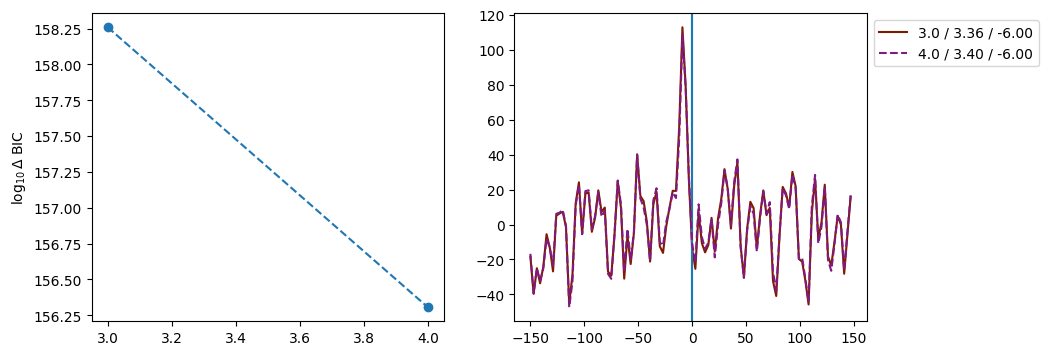

In [15]:
# plot the 1D CCF for all n_pcas

index12 = 1
# remove orders if necessary
# or to check the contribution of specific bands only
orders = np.arange(75) #list(nf.remove_values_from_array(bands(t1.wv,'yjhk'), []+nf.ord_frac_tresh(t1, 0.0)))

loglBL_grid_t123 = loblBL_t1_corr
loglBL_grid_t123_sig = loblBL_t1_sig
t=list_tr['1']

log12_single0 = Correlations(loglBL_grid_t123, kind="logl", rv_grid=corrRV, 
                             n_pcas=n_pcas, kp_array=np.array([0]))
log12_single0.calc_logl(t, orders=orders, index=index12, N=None, nolog=False, icorr=t.iIn)
# if the peak has an offset from 0, can give an approximate value to RV_sys to look for a peak elsewhere
# (I think)
log12_single0.plot_multi_npca(RV_sys=0.0, title='CCF SNR')

log12s_single0 = Correlations(loglBL_grid_t123_sig, kind="logl", rv_grid=corrRV, 
                              n_pcas=n_pcas, kp_array=np.array([0]))
log12s_single0.calc_logl(t, orders=orders, index=index12, N=t.N, nolog=True,  icorr=t.iIn)
# log12s_single0.plot_multi_npca(RV_sys=t1.RV_sys, title='logL SNR')

log12s_single0.plot_multi_npca(RV_sys=t.planet.RV_sys.value, kind='courbe', kind_courbe='abs', title='logL abs')
log12s_single0.plot_multi_npca(RV_sys=t.planet.RV_sys.value, kind='courbe', kind_courbe='bic', 
                              title=r'$\log_{10} \Delta$ BIC')

print(log12_single0.npc_val)
print(log12s_single0.npc_max_abs)
print(log12s_single0.npc_bic)
print(2*(log12s_single0.npc_max_abs-log12s_single0.npc_max_abs[0]))

(56, 100, 2)


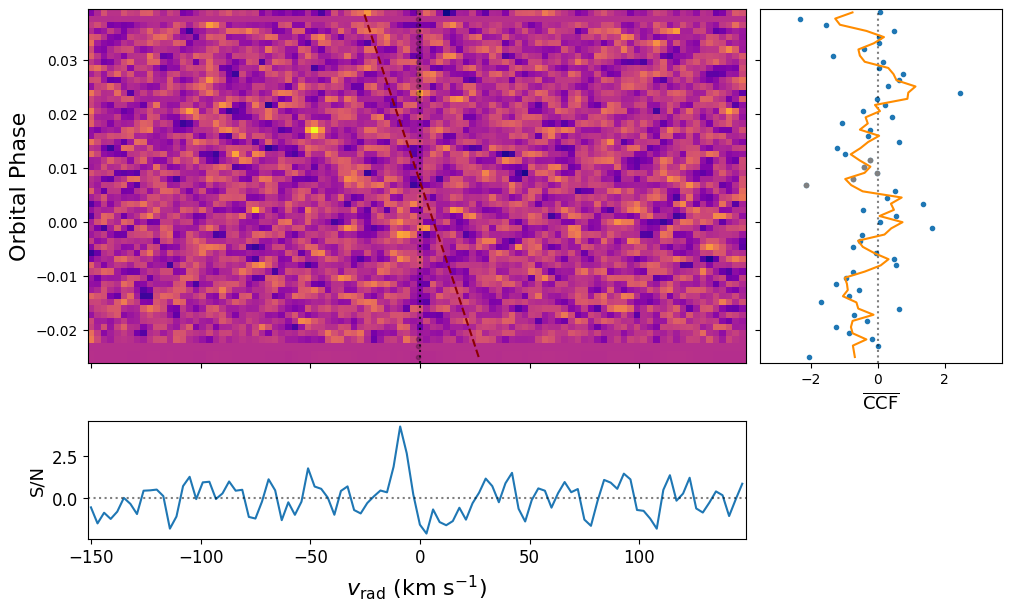

In [17]:
# plot the CCF per exposure for a specific number of PCs removed
# give the array indexing of the n_pc to check
id_pc=0
t=list_tr['1']

# specify a path and name if you want to save this plot
# path_fig = '/Users/fredericg/doctorat/saved_correl/figures/'
path_fig=None
# fig_name = 'WASP-127b_nPC_4_tellu_30'
fig_name = None

# log12_single0.pos=0.0
log12_single0.plot_PRF( t, RV=-1., icorr=None, 
#                       split_fig=[0, t1.n_spec, t1.n_spec+t2.n_spec],
                     kind='logl_corr', index=index12, remove_mean=True,# [62,63],
#                         hlines=[[2,t1.phase[t1.iIn[0]], ':', 'w'], 
#                                 [1,t2.phase[t2.iIn[0]], ':','w'], ],
#                      texts=[[2, corrRV0[4], t1.phase[-9],'Tr1'],[1, corrRV0[4], t2.phase[-6],'Tr2']], 
                      path_fig=path_fig, fig_name=fig_name, 
                       extension='.pdf', map_kind='snr', id_pc=id_pc,
                      figwidth=9)

# log12_single0.ttest_value(t, kind='logl', vrp=np.zeros_like(t.vrp).value, 
#                              plot=False, speed_limit=3, peak_center=30, equal_var=False)